# Capstone Phase 2 - SVM  
Previous phase 2 notebook was getting a bit long, so modeling is continued here.

### Import some libraries we'll need

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

### Some utility stuff

In [4]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [5]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [6]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

### Load data and apply transformations identified during exploration phase

In [7]:
with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [8]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [9]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [10]:
class_names = list(label_encoder.classes_)

### Load feature subsets

In [11]:
feature_subsets = joblib.load('./data/feature_subsets.pkl')

In [12]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)
rf.fit(X=training_data_std, y=y_train)  # let's try the full set first

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1)

In [15]:
y_pred_rf = cross_val_predict(rf, training_data_std, y_train, cv=3, n_jobs=-1)  # save the test set for final models

In [16]:
y_pred_rf

array([6, 6, 3, ..., 5, 5, 5])

In [19]:
joblib.dump(rf, './data/rf-100-16.pkl')

['./data/rf-100-16.pkl']

In [14]:
rf = joblib.load('./data/rf-100-16.pkl')

That was pretty quick, let's run a grid-search to look for parameters before going further

In [19]:
params = {'n_estimators':[100, 200, 500], 'max_leaf_nodes':[8, 16, 32], 'class_weight':['balanced', 'balanced_subsample']}
rf_gs = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [20]:
rf_gs_results = rf_gs.fit(training_data_std, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [25]:
joblib.dump(rf_gs, './data/rf_gs.pkl')
joblib.dump(rf_gs_results, './data/rf_gs_results')

['./data/rf_gs_results']

In [21]:
print(rf_gs_results.best_estimator_)
print(rf_gs_results.best_params_)
print(rf_gs_results.best_score_)

RandomForestClassifier(class_weight='balanced_subsample', max_leaf_nodes=32,
                       n_estimators=500)
{'class_weight': 'balanced_subsample', 'max_leaf_nodes': 32, 'n_estimators': 500}
0.676920971136243


The number of estimators and leaf nodes are the maximum values in our search, maybe we should try going higher.

In [22]:
params_2 = {'n_estimators':[500, 750, 1000], 'max_leaf_nodes':[32, 64, 128]}
rf_gs_2 = GridSearchCV(RandomForestClassifier(class_weight='balanced_subsample'), params_2, cv=3, 
                       scoring='accuracy', verbose=2, n_jobs=-1)

In [23]:
rf_gs_2_results = rf_gs_2.fit(training_data_std, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [26]:
joblib.dump(rf_gs_2, './data/rf_gs_2.pkl')
joblib.dump(rf_gs_2_results, './data/rf_gs_2_results')

['./data/rf_gs_2_results']

In [24]:
print(rf_gs_2_results.best_params_)
print(rf_gs_2_results.best_score_)

{'max_leaf_nodes': 128, 'n_estimators': 750}
0.7117673561802431


In [32]:
rf_best = RandomForestClassifier(n_estimators=750, max_leaf_nodes=128, class_weight='balanced_subsample', n_jobs=-1)
rf_best.fit(X=training_data_std, y=y_train)  # let's try the full set first

RandomForestClassifier(class_weight='balanced_subsample', max_leaf_nodes=128,
                       n_estimators=750, n_jobs=-1)

In [33]:
joblib.dump(rf_best, './data/rf_best.pkl')

['./data/rf_best.pkl']

In [34]:
# save the test set for final models
y_pred_rf_best = cross_val_predict(rf_best, training_data_std, y_train, cv=3, n_jobs=-1)

In [35]:
y_pred_rf_best

array([1, 6, 3, ..., 5, 5, 5])

In [48]:
#for feature, importance in zip(training_data_std.columns, rf_best.feature_importances_):
#    print(feature, importance)
feature_importances = [(x, y) for x, y in zip(training_data_std.columns, rf_best.feature_importances_)]
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

In [50]:
joblib.dump(sorted_importances, './data/sorted_feature_importances.pkl')

['./data/sorted_feature_importances.pkl']

              precision    recall  f1-score   support

           0       0.16      0.31      0.21      2000
           1       0.05      0.70      0.09      1746
           2       0.34      0.14      0.20     12264
           3       0.86      0.43      0.58     33393
           4       0.54      0.85      0.66     18184
           5       1.00      0.98      0.99     40000
           6       1.00      0.72      0.84     56000
           7       0.77      0.82      0.79     10491
           8       0.26      0.93      0.40      1133
           9       0.07      0.80      0.12       130

    accuracy                           0.70    175341
   macro avg       0.50      0.67      0.49    175341
weighted avg       0.84      0.70      0.74    175341



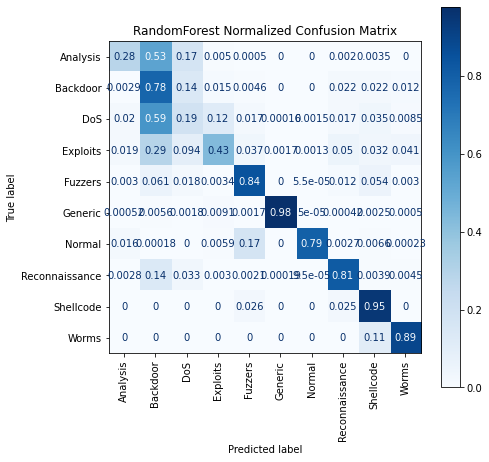

In [51]:
conf_mat_rf_best, class_rep_rf_best, rep_dict_rf_best, acc_rf_best = gen_metrics(y_train, y_pred_rf_best)
print(class_rep_rf_best)
plt_norm_confmat(rf_best, training_data_std, y_train, 'RandomForest Normalized Confusion Matrix', 
                 fname='rf_best_conf_mat', labels=class_names)
plt.show()

That looks decent.  Are there other parameters we should conisder tuning to improve the results?  
We should also train on each of the feature subsets so we can compare fairly with the previous models.  We may also want to go back and use the most important features identified here on the earlier models to see if performance improves.

I also wonder if more leaf nodes are needed, we settled on 128, but that was the highest value searched...

In [54]:
params_3 = {'max_leaf_nodes':[128, 192, 256, 320]}
rf_gs_3 = GridSearchCV(RandomForestClassifier(n_estimators=750, class_weight='balanced_subsample'), params_3, cv=3, 
                       scoring='accuracy', verbose=2, n_jobs=-1)

In [55]:
rf_gs_3_results = rf_gs_3.fit(training_data_std, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [56]:
print(rf_gs_3_results.best_params_)
print(rf_gs_3_results.best_score_)

{'max_leaf_nodes': 320}
0.723618548998808


slightly better accuracy...but still hitting that top value...is it worth going higher?

In [57]:
params_4 = {'max_leaf_nodes':[320, 384, 448, 512]}
rf_gs_4 = GridSearchCV(RandomForestClassifier(n_estimators=750, class_weight='balanced_subsample'), params_4, cv=3, 
                       scoring='accuracy', verbose=2, n_jobs=-1)

In [58]:
rf_gs_4_results = rf_gs_4.fit(training_data_std, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [59]:
print(rf_gs_4_results.best_params_)
print(rf_gs_4_results.best_score_)

{'max_leaf_nodes': 512}
0.728785623442321


.5% better than the last run, maybe we're nearing the limit...but maybe just set it to `None` for unlimited leaves?

In [60]:
rf_best_new = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', n_jobs=-1)
rf_best_new.fit(X=training_data_std, y=y_train)  # let's try the full set first

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=750,
                       n_jobs=-1)

In [61]:
# save the test set for final models
y_pred_rf_best_new = cross_val_predict(rf_best_new, training_data_std, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.04      0.12      0.07      2000
           1       0.06      0.20      0.09      1746
           2       0.31      0.29      0.30     12264
           3       0.73      0.61      0.66     33393
           4       0.53      0.68      0.60     18184
           5       0.90      0.98      0.94     40000
           6       0.90      0.78      0.83     56000
           7       0.89      0.74      0.81     10491
           8       0.66      0.63      0.65      1133
           9       0.66      0.18      0.28       130

    accuracy                           0.73    175341
   macro avg       0.57      0.52      0.52    175341
weighted avg       0.77      0.73      0.74    175341



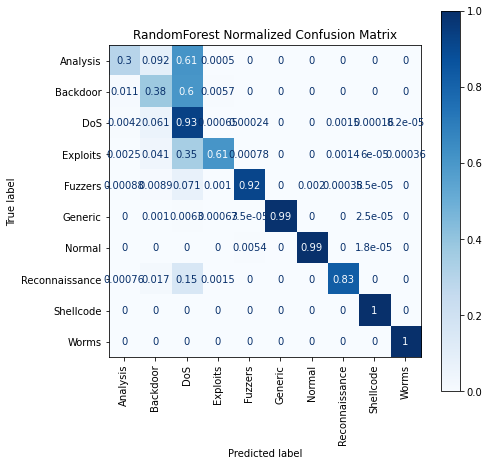

In [62]:
conf_mat_rf_best_new, class_rep_rf_best_new, rep_dict_rf_best_new, acc_rf_best_new = gen_metrics(y_train, y_pred_rf_best_new)
print(class_rep_rf_best_new)
plt_norm_confmat(rf_best_new, training_data_std, y_train, 'RandomForest Normalized Confusion Matrix', 
                 fname='rf_best_new_conf_mat', labels=class_names)
plt.show()

In [65]:
joblib.dump(rf_best_new, './data/rf_best_new.pkl')

['./data/rf_best_new.pkl']

This is looking better, what are the feature importances?  
What other parameters could we tune?

In [14]:
params_5 = {'criterion':['gini', 'entropy'], 'min_samples_split':[2, 4, 8], 'min_samples_leaf':[1,2,4]}
rf_gs_5 = GridSearchCV(RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample'), 
                       params_5, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [15]:
rf_gs_5_results = rf_gs_5.fit(training_data_std, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [17]:
joblib.dump(rf_gs_5, './data/rf_gs_5.pkl')
joblib.dump(rf_gs_5_results, './data/rf_gs_5_results.pkl')

['./data/rf_gs_5_results.pkl']

In [15]:
#rf_gs_5 = joblib.load('./data/rf_gs_5.pkl')
#rf_gs_5_results = joblib.load('./data/rf_gs_5_results.pkl')

In [16]:
print(rf_gs_5_results.best_params_)
print(rf_gs_5_results.best_score_)

{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 8}
0.7392053199194711


Looks like the `criterion` and `min_samples_leaf` are OK, let's try one more search for `min_samples_split`

In [18]:
params_6 = {'min_samples_split':[8, 12, 16, 20]}
rf_gs_6 = GridSearchCV(RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                                              criterion='gini', min_samples_leaf=2), 
                       params_6, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [19]:
rf_gs_6_results = rf_gs_6.fit(training_data_std, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [19]:
joblib.dump(rf_gs_6, './data/rf_gs_6.pkl')
joblib.dump(rf_gs_6_results, './data/rf_gs_6_results.pkl')

['./data/rf_gs_6_results.pkl']

In [18]:
#rf_gs_6 = joblib.load('./data/rf_gs_6.pkl')
#rf_gs_6_results = joblib.load('./data/rf_gs_6_results.pkl')

In [20]:
print(rf_gs_6_results.best_params_)
print(rf_gs_6_results.best_score_)

{'min_samples_split': 12}
0.7397528244962673


That's looks like the best we can do (for now at least), let's fit that model on our training data, make some predictions, and check some classification metrics. 

In [21]:
rf_best_3 = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                       criterion='gini', min_samples_leaf=2, min_samples_split=12)
rf_best_3.fit(X=training_data_std, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [25]:
joblib.dump(rf_best_3, './data/rf_best_3.pkl')

['./data/rf_best_3.pkl']

In [14]:
rf_best_3 = joblib.load('./data/rf_best_3.pkl')

In [15]:
# save the test set for final models
y_pred_rf_best_3 = cross_val_predict(rf_best_3, training_data_std, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.07      0.25      0.11      2000
           1       0.06      0.31      0.10      1746
           2       0.32      0.36      0.34     12264
           3       0.82      0.54      0.65     33393
           4       0.54      0.80      0.65     18184
           5       0.99      0.98      0.98     40000
           6       0.96      0.77      0.85     56000
           7       0.83      0.80      0.82     10491
           8       0.43      0.88      0.58      1133
           9       0.54      0.52      0.53       130

    accuracy                           0.74    175341
   macro avg       0.56      0.62      0.56    175341
weighted avg       0.82      0.74      0.77    175341



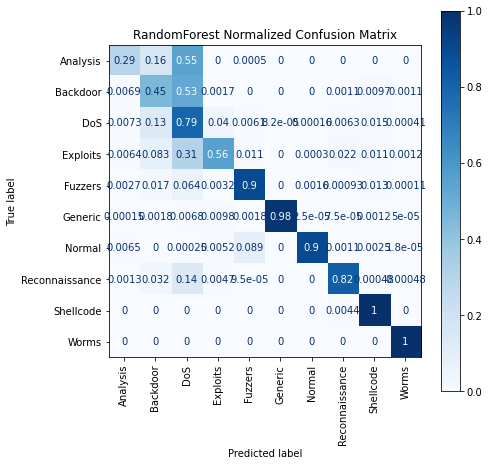

In [16]:
conf_mat_rf_best_3, class_rep_rf_best_3, rep_dict_rf_best_3, acc_rf_best_3 = gen_metrics(y_train, y_pred_rf_best_3)
print(class_rep_rf_best_3)
plt_norm_confmat(rf_best_3, training_data_std, y_train, 'RandomForest Normalized Confusion Matrix', 
                 fname='rf_best_3_conf_mat', labels=class_names)
plt.show()

This looks pretty good - it may be the best we can do.  

In [17]:
joblib.dump(rep_dict_rf_best_3, './data/rep_dict_rf_best_3.pkl')

['./data/rep_dict_rf_best_3.pkl']

Let's save those feature importance in case we want to back port them and try them on the earlier models.

In [57]:
rfb3_feature_importances = [(x, y) for x, y in zip(training_data_std.columns, rf_best_3.feature_importances_)]
rfb3_sorted_importances = sorted(rfb3_feature_importances, key=lambda x: x[1], reverse=True)

joblib.dump(rfb3_sorted_importances, './data/rfb3_sorted_feature_importances.pkl')

['./data/rfb3_sorted_feature_importances.pkl']

Let's see what effect using the different feature subsets has on a model with these parameters.

In [19]:
rfb3_ig = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                       criterion='gini', min_samples_leaf=2, min_samples_split=12)
rfb3_ig.fit(X=train_std_ig, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [20]:
joblib.dump(rfb3_ig, './data/rfb3_ig.pkl')

['./data/rfb3_ig.pkl']

In [21]:
# save the test set for final models
y_pred_rfb3_ig = cross_val_predict(rfb3_ig, train_std_ig, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.06      0.22      0.10      2000
           1       0.06      0.33      0.10      1746
           2       0.34      0.39      0.36     12264
           3       0.83      0.54      0.65     33393
           4       0.53      0.78      0.63     18184
           5       1.00      0.98      0.99     40000
           6       0.95      0.77      0.85     56000
           7       0.84      0.78      0.81     10491
           8       0.43      0.80      0.56      1133
           9       0.48      0.72      0.57       130

    accuracy                           0.74    175341
   macro avg       0.55      0.63      0.56    175341
weighted avg       0.82      0.74      0.77    175341



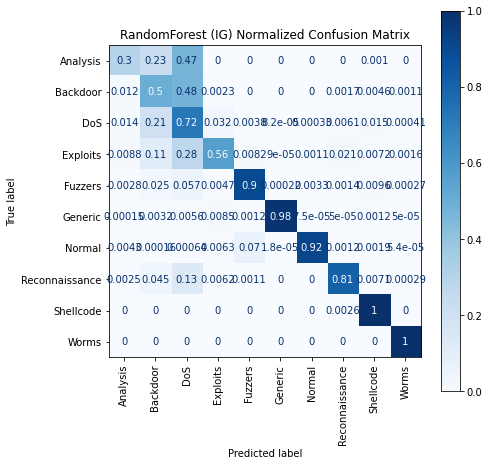

In [22]:
conf_mat_rfb3_ig, class_rep_rfb3_ig, rep_dict_rfb3_ig, acc_rfb3_ig = gen_metrics(y_train, y_pred_rfb3_ig)
print(class_rep_rfb3_ig)
plt_norm_confmat(rfb3_ig, train_std_ig, y_train, 'RandomForest (IG) Normalized Confusion Matrix', 
                 fname='rfb3_ig_conf_mat', labels=class_names)
plt.show()

In [23]:
joblib.dump(rep_dict_rfb3_ig, './data/rep_dict_rfb3_ig.pkl')

['./data/rep_dict_rfb3_ig.pkl']

Looks much the same as using all features.  Presumably any subset should, since the parameters were tuned using the full feature set.  
Let's continue....

In [24]:
rfb3_anova = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                       criterion='gini', min_samples_leaf=2, min_samples_split=12)
rfb3_anova.fit(X=train_std_anova, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [25]:
joblib.dump(rfb3_anova, './data/rfb3_anova.pkl')

['./data/rfb3_anova.pkl']

In [26]:
# save the test set for final models
y_pred_rfb3_anova = cross_val_predict(rfb3_anova, train_std_anova, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.06      0.17      0.08      2000
           1       0.04      0.16      0.07      1746
           2       0.25      0.28      0.26     12264
           3       0.77      0.51      0.62     33393
           4       0.48      0.71      0.57     18184
           5       0.93      0.97      0.95     40000
           6       0.94      0.73      0.82     56000
           7       0.55      0.54      0.55     10491
           8       0.09      0.33      0.14      1133
           9       0.18      0.15      0.17       130

    accuracy                           0.68    175341
   macro avg       0.43      0.46      0.42    175341
weighted avg       0.76      0.68      0.71    175341



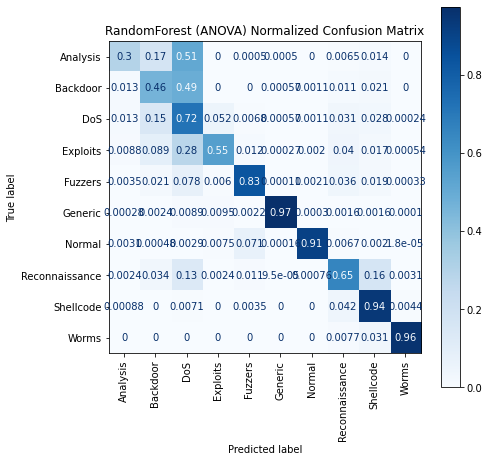

In [27]:
conf_mat_rfb3_anova, class_rep_rfb3_anova, rep_dict_rfb3_anova, acc_rfb3_anova = gen_metrics(y_train, y_pred_rfb3_anova)
print(class_rep_rfb3_anova)
plt_norm_confmat(rfb3_anova, train_std_anova, y_train, 'RandomForest (ANOVA) Normalized Confusion Matrix', 
                 fname='rfb3_anova_conf_mat', labels=class_names)
plt.show()

In [28]:
joblib.dump(rep_dict_rfb3_anova, './data/rep_dict_rfb3_anova.pkl')

['./data/rep_dict_rfb3_anova.pkl']

Performance looks slightly worse with those features...moving on

In [29]:
rfb3_vt = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                       criterion='gini', min_samples_leaf=2, min_samples_split=12)
rfb3_vt.fit(X=train_std_vt, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [30]:
joblib.dump(rfb3_vt, './data/rfb3_vt.pkl')

['./data/rfb3_vt.pkl']

In [31]:
# save the test set for final models
y_pred_rfb3_vt = cross_val_predict(rfb3_vt, train_std_vt, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.09      0.18      0.12      2000
           1       0.06      0.48      0.11      1746
           2       0.36      0.37      0.36     12264
           3       0.79      0.52      0.63     33393
           4       0.53      0.77      0.63     18184
           5       1.00      0.98      0.99     40000
           6       0.96      0.76      0.85     56000
           7       0.82      0.78      0.80     10491
           8       0.27      0.48      0.35      1133
           9       0.39      0.63      0.48       130

    accuracy                           0.73    175341
   macro avg       0.53      0.60      0.53    175341
weighted avg       0.82      0.73      0.76    175341



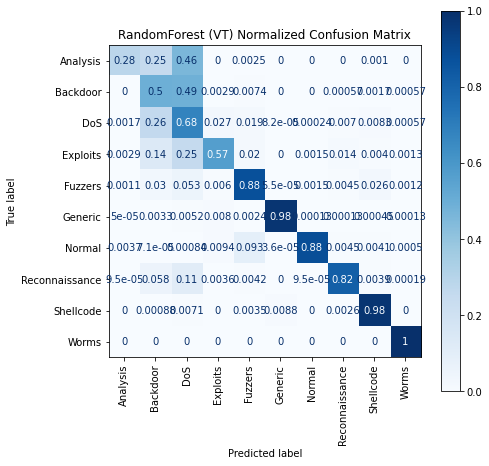

In [32]:
conf_mat_rfb3_vt, class_rep_rfb3_vt, rep_dict_rfb3_vt, acc_rfb3_vt = gen_metrics(y_train, y_pred_rfb3_vt)
print(class_rep_rfb3_vt)
plt_norm_confmat(rfb3_vt, train_std_vt, y_train, 'RandomForest (VT) Normalized Confusion Matrix', 
                 fname='rfb3_vt_conf_mat', labels=class_names)
plt.show()

In [33]:
joblib.dump(rep_dict_rfb3_vt, './data/rep_dict_rfb3_vt.pkl')

['./data/rep_dict_rfb3_vt.pkl']

Again, similar to the full set, but not quite as good.  Next....

In [34]:
rfb3_mad = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                       criterion='gini', min_samples_leaf=2, min_samples_split=12)
rfb3_mad.fit(X=train_std_mad, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [35]:
joblib.dump(rfb3_mad, './data/rfb3_mad.pkl')

['./data/rfb3_mad.pkl']

In [36]:
# save the test set for final models
y_pred_rfb3_mad = cross_val_predict(rfb3_mad, train_std_mad, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.06      0.20      0.09      2000
           1       0.07      0.25      0.11      1746
           2       0.33      0.41      0.37     12264
           3       0.82      0.55      0.66     33393
           4       0.53      0.78      0.63     18184
           5       0.98      0.98      0.98     40000
           6       0.95      0.77      0.85     56000
           7       0.84      0.78      0.81     10491
           8       0.41      0.79      0.54      1133
           9       0.47      0.69      0.56       130

    accuracy                           0.74    175341
   macro avg       0.55      0.62      0.56    175341
weighted avg       0.81      0.74      0.77    175341



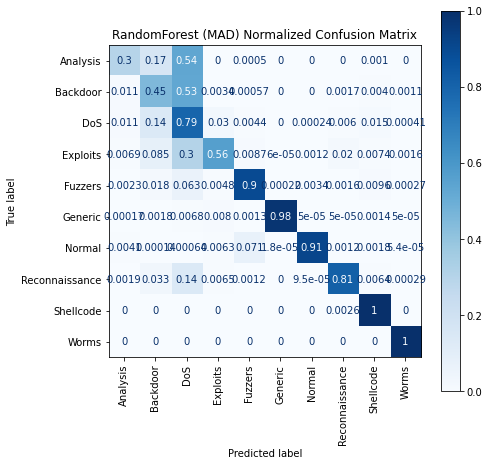

In [37]:
conf_mat_rfb3_mad, class_rep_rfb3_mad, rep_dict_rfb3_mad, acc_rfb3_mad = gen_metrics(y_train, y_pred_rfb3_mad)
print(class_rep_rfb3_mad)
plt_norm_confmat(rfb3_mad, train_std_mad, y_train, 'RandomForest (MAD) Normalized Confusion Matrix', 
                 fname='rfb3_mad_conf_mat', labels=class_names)
plt.show()

In [38]:
joblib.dump(rep_dict_rfb3_mad, './data/rep_dict_rfb3_mad.pkl')

['./data/rep_dict_rfb3_mad.pkl']

Similar results to the full feature set.  Next....

In [39]:
rfb3_corr = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                       criterion='gini', min_samples_leaf=2, min_samples_split=12)
rfb3_corr.fit(X=train_std_corr, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [40]:
joblib.dump(rfb3_corr, './data/rfb3_corr.pkl')

['./data/rfb3_corr.pkl']

In [41]:
# save the test set for final models
y_pred_rfb3_corr = cross_val_predict(rfb3_corr, train_std_corr, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.11      0.19      0.14      2000
           1       0.06      0.49      0.10      1746
           2       0.35      0.33      0.34     12264
           3       0.80      0.52      0.63     33393
           4       0.52      0.78      0.63     18184
           5       1.00      0.98      0.99     40000
           6       0.95      0.76      0.85     56000
           7       0.86      0.78      0.82     10491
           8       0.26      0.58      0.35      1133
           9       0.48      0.60      0.53       130

    accuracy                           0.73    175341
   macro avg       0.54      0.60      0.54    175341
weighted avg       0.82      0.73      0.76    175341



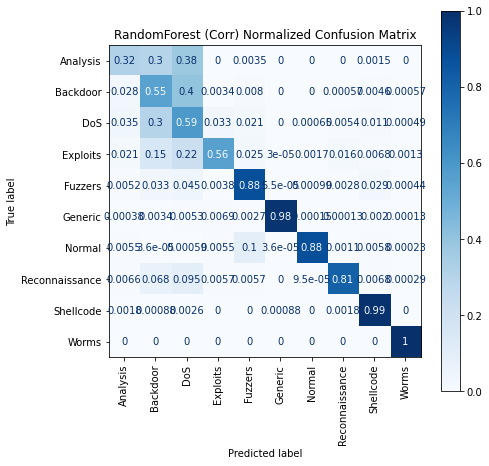

In [42]:
conf_mat_rfb3_corr, class_rep_rfb3_corr, rep_dict_rfb3_corr, acc_rfb3_corr = gen_metrics(y_train, y_pred_rfb3_corr)
print(class_rep_rfb3_corr)
plt_norm_confmat(rfb3_corr, train_std_corr, y_train, 'RandomForest (Corr) Normalized Confusion Matrix', 
                 fname='rfb3_corr_conf_mat', labels=class_names)
plt.show()

In [43]:
joblib.dump(rep_dict_rfb3_corr, './data/rep_dict_rfb3_corr.pkl')

['./data/rep_dict_rfb3_corr.pkl']

Next...

In [44]:
rfb3_rfe = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                       criterion='gini', min_samples_leaf=2, min_samples_split=12)
rfb3_rfe.fit(X=train_std_rfe, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [45]:
joblib.dump(rfb3_rfe, './data/rfb3_rfe.pkl')

['./data/rfb3_rfe.pkl']

In [46]:
# save the test set for final models
y_pred_rfb3_rfe = cross_val_predict(rfb3_rfe, train_std_rfe, y_train, cv=3, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.08      0.25      0.12      2000
           1       0.06      0.30      0.10      1746
           2       0.32      0.37      0.34     12264
           3       0.82      0.54      0.65     33393
           4       0.54      0.80      0.65     18184
           5       0.99      0.98      0.98     40000
           6       0.96      0.76      0.85     56000
           7       0.83      0.80      0.82     10491
           8       0.43      0.89      0.58      1133
           9       0.55      0.52      0.53       130

    accuracy                           0.74    175341
   macro avg       0.56      0.62      0.56    175341
weighted avg       0.82      0.74      0.77    175341



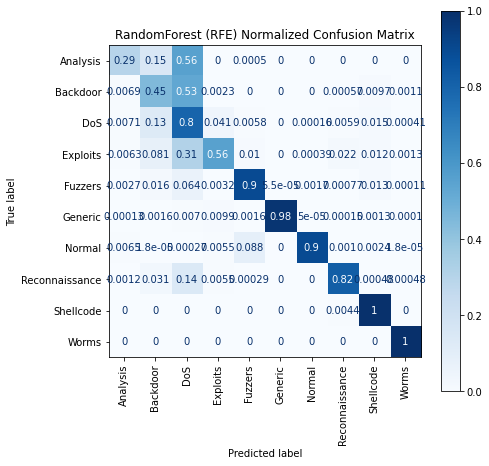

In [47]:
conf_mat_rfb3_rfe, class_rep_rfb3_rfe, rep_dict_rfb3_rfe, acc_rfb3_rfe = gen_metrics(y_train, y_pred_rfb3_rfe)
print(class_rep_rfb3_rfe)
plt_norm_confmat(rfb3_rfe, train_std_rfe, y_train, 'RandomForest (RFE) Normalized Confusion Matrix', 
                 fname='rfb3_rfe_conf_mat', labels=class_names)
plt.show()

In [48]:
joblib.dump(rep_dict_rfb3_rfe, './data/rep_dict_rfb3_rfe.pkl')

['./data/rep_dict_rfb3_rfe.pkl']

Since the Recursive Feature Elimination subset used most of the features, it's as expected that these results look much the same as those from the full set.

Let's plot those individual class F1 scores

In [20]:
import seaborn as sns

In [21]:
rep_dict_rfb3_ig = joblib.load('./data/rep_dict_rfb3_ig.pkl')
rep_dict_rfb3_anova = joblib.load('./data/rep_dict_rfb3_anova.pkl')
rep_dict_rfb3_vt = joblib.load('./data/rep_dict_rfb3_vt.pkl')
rep_dict_rfb3_mad = joblib.load('./data/rep_dict_rfb3_mad.pkl')
rep_dict_rfb3_corr = joblib.load('./data/rep_dict_rfb3_corr.pkl')
rep_dict_rfb3_rfe = joblib.load('./data/rep_dict_rfb3_rfe.pkl')
rep_dict_rf_best_3 = joblib.load('./data/rep_dict_rf_best_3.pkl')

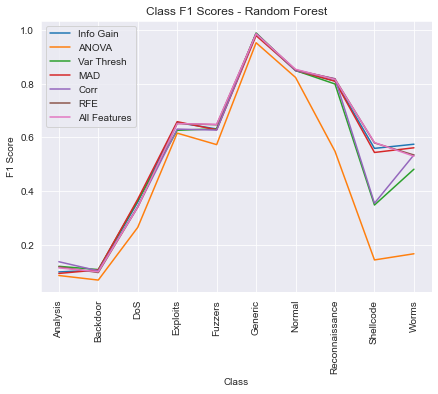

In [51]:
rfb3_reports = [rep_dict_rfb3_ig, rep_dict_rfb3_anova, rep_dict_rfb3_vt, rep_dict_rfb3_mad, 
                rep_dict_rfb3_corr, rep_dict_rfb3_rfe, rep_dict_rf_best_3]
rfb3_lgnds = ['Info Gain', 'ANOVA', 'Var Thresh', 'MAD', 'Corr', 'RFE', 'All Features']
labels = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')

for report, lgnd in zip(rfb3_reports, rfb3_lgnds):
    f1_scores = []
    for lab in labels:
        f1_scores.append(report[lab]['f1-score'])
    sns.lineplot(x=label_encoder.classes_, y=f1_scores, label=lgnd)
plt.xlabel('Class')
plt.xticks(rotation=90, horizontalalignment='center')
plt.ylabel('F1 Score')
plt.title('Class F1 Scores - Random Forest')
plt.legend()
plt.savefig('./images/class_f1s_rfb3.png', dpi=300, bbox_inches='tight')
plt.show()

Remember these values aren't normalized.

Now let's look at overall model accuracy and weighted average F1 scores.

In [22]:
# let's grab come metrics so we can plot them togther
rfb3_acc = [('Accuracy', 'Info Gain', rep_dict_rfb3_ig['accuracy']),
                  ('Accuracy', 'ANOVA', rep_dict_rfb3_anova['accuracy']),
                  ('Accuracy', 'Var Thresh', rep_dict_rfb3_vt['accuracy']),
                  ('Accuracy', 'MAD', rep_dict_rfb3_mad['accuracy']),
                  ('Accuracy', 'Corr', rep_dict_rfb3_corr['accuracy']),
                  ('Accuracy', 'RFE', rep_dict_rfb3_rfe['accuracy']),
                  ('Accuracy', 'All', rep_dict_rf_best_3['accuracy']),
                  ('Weighted Avg F1', 'Info Gain', rep_dict_rfb3_ig['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'ANOVA', rep_dict_rfb3_anova['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'Var Thresh', rep_dict_rfb3_vt['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'MAD', rep_dict_rfb3_mad['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'Corr', rep_dict_rfb3_corr['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'RFE', rep_dict_rfb3_rfe['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'All', rep_dict_rf_best_3['weighted avg']['f1-score'])]
rfb3_metric_df = pd.DataFrame(rfb3_acc, columns=['Metric', 'Feature Subset', 'Score'])

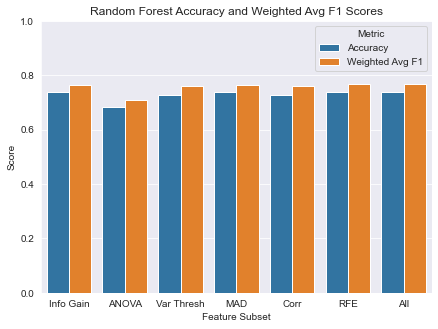

In [23]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
rfb3_metric_chart = sns.barplot(x='Feature Subset', y='Score', hue='Metric', data=rfb3_metric_df)
rfb3_metric_chart.set_title('Random Forest Accuracy and Weighted Avg F1 Scores')
plt.ylim(ymax=1.0)
#plt.legend(loc='lower right')
plt.savefig('./images/feat_subset_acc_f1_rfb3.png', dpi=300, bbox_inches='tight')
plt.show()

So, as expected this model that was tuned on the full set of features shows roughly similar performance with various subsets of features.  Some feature subsets perform worse on certain specific classes.

Let's also train one on the set of optimal features found, so that we can compare directly with the other models.

In [15]:
sorted_features = joblib.load('./data/rfb3_sorted_feature_importances.pkl')

top_feats = [x[0] for x in sorted_features if x[1] > 1e-3]
len(top_feats)

train_std_RF = training_data_std[top_feats].copy()
test_std_RF = testing_data_std[top_feats].copy()

In [16]:
rfb3_RF = RandomForestClassifier(n_estimators=750, max_leaf_nodes=None, class_weight='balanced_subsample', 
                                 criterion='gini', min_samples_leaf=2, min_samples_split=12)

In [17]:
rfb3_RF.fit(X=train_std_RF, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=750)

In [18]:
joblib.dump(rfb3_RF, './data/rfb3_RF.pkl')

['./data/rfb3_RF.pkl']

## Model evaluation

In [19]:
rf_ig_final = joblib.load('./data/rfb3_ig.pkl')
rf_anova_final = joblib.load('./data/rfb3_anova.pkl')
rf_vt_final = joblib.load('./data/rfb3_vt.pkl')
rf_mad_final = joblib.load('./data/rfb3_mad.pkl')
rf_corr_final = joblib.load('./data/rfb3_corr.pkl')
rf_rfe_final = joblib.load('./data/rfb3_rfe.pkl') #recursive feature elimination
rf_RF_final = joblib.load('./data/rfb3_RF.pkl') #model trained on the top 50 features
rf_all_final = joblib.load('./data/rf_best_3.pkl') #all features

In [15]:
rfb3_sorted_importances = joblib.load('./data/rfb3_sorted_feature_importances.pkl')

top_feats = [x[0] for x in rfb3_sorted_importances if x[1] > 1e-3]

train_std_RF = training_data_std[top_feats].copy()
test_std_RF = testing_data_std[top_feats].copy()

### Info Gain features

In [16]:
y_pred_final_rf_ig = rf_ig_final.predict(test_std_ig)

In [17]:
final_conf_mat_rf_ig, final_class_rep_rf_ig, final_rep_dict_rf_ig, final_acc_rf_ig = gen_metrics(y_test, y_pred_final_rf_ig)
print(final_class_rep_rf_ig)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.16      0.07      0.09      4089
           3       0.39      0.70      0.50     11132
           4       0.16      0.62      0.26      6062
           5       1.00      0.57      0.73     18871
           6       0.89      0.63      0.74     37000
           7       1.00      0.02      0.04      3496
           8       0.00      0.00      0.00       378
           9       0.20      0.02      0.04        44

    accuracy                           0.56     82332
   macro avg       0.38      0.26      0.24     82332
weighted avg       0.74      0.56      0.59     82332



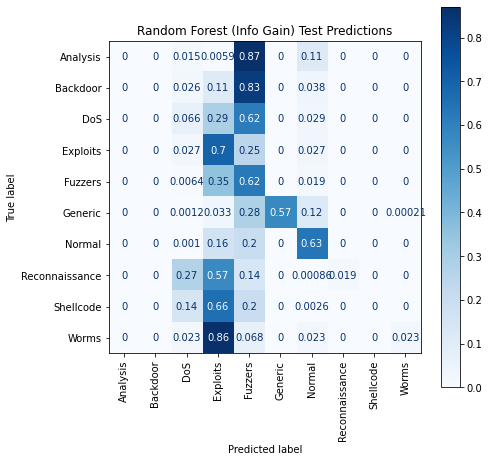

In [18]:
plt_norm_confmat(rf_ig_final, test_std_ig, y_test, 'Random Forest (Info Gain) Test Predictions', 
                 fname='final_rf_ig_conf_mat', labels=class_names)

In [19]:
joblib.dump(final_rep_dict_rf_ig, './data/final_rep_dict_rf_ig.pkl')

['final_rep_dict_rf_ig.pkl']

In [20]:
joblib.dump(final_conf_mat_rf_ig, './data/final_conf_mat_rf_ig.pkl')

['final_conf_mat_rf_ig.pkl']

### ANOVA features

In [21]:
y_pred_final_rf_anova = rf_anova_final.predict(test_std_anova)

In [22]:
final_conf_mat_rf_anova, final_class_rep_rf_anova, final_rep_dict_rf_anova, final_acc_rf_anova = gen_metrics(y_test, y_pred_final_rf_anova)
print(final_class_rep_rf_anova)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.02      0.07      0.03       583
           2       0.24      0.31      0.27      4089
           3       0.55      0.65      0.60     11132
           4       0.22      0.71      0.34      6062
           5       0.84      0.79      0.81     18871
           6       0.97      0.63      0.76     37000
           7       0.69      0.00      0.01      3496
           8       0.00      0.00      0.00       378
           9       0.67      0.09      0.16        44

    accuracy                           0.62     82332
   macro avg       0.42      0.33      0.30     82332
weighted avg       0.76      0.62      0.65     82332



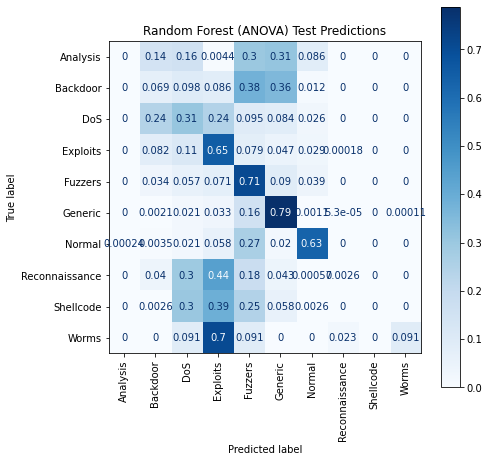

In [23]:
plt_norm_confmat(rf_anova_final, test_std_anova, y_test, 'Random Forest (ANOVA) Test Predictions', 
                 fname='final_rf_anova_conf_mat', labels=class_names)

In [24]:
joblib.dump(final_rep_dict_rf_anova, './data/final_rep_dict_rf_anova.pkl')

['final_rep_dict_rf_anova.pkl']

In [25]:
joblib.dump(final_conf_mat_rf_anova, './data/final_conf_mat_rf_anova.pkl')

['final_conf_mat_rf_anova.pkl']

### Variance Threshold features

In [26]:
y_pred_final_rf_vt = rf_vt_final.predict(test_std_vt)

In [27]:
final_conf_mat_rf_vt, final_class_rep_rf_vt, final_rep_dict_rf_vt, final_acc_rf_vt = gen_metrics(y_test, y_pred_final_rf_vt)
print(final_class_rep_rf_vt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       1.00      0.00      0.00       583
           2       0.38      0.02      0.04      4089
           3       0.29      0.71      0.41     11132
           4       0.10      0.31      0.15      6062
           5       0.00      0.00      0.00     18871
           6       0.65      0.61      0.63     37000
           7       0.00      0.00      0.00      3496
           8       0.00      0.00      0.00       378
           9       0.80      0.09      0.16        44

    accuracy                           0.39     82332
   macro avg       0.32      0.17      0.14     82332
weighted avg       0.36      0.39      0.35     82332



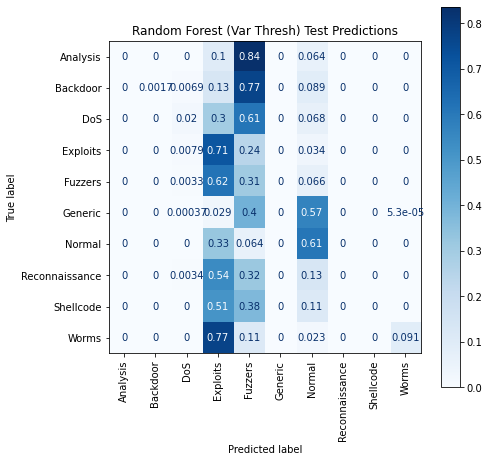

In [28]:
plt_norm_confmat(rf_vt_final, test_std_vt, y_test, 'Random Forest (Var Thresh) Test Predictions', 
                 fname='final_rf_vt_conf_mat', labels=class_names)

In [29]:
joblib.dump(final_rep_dict_rf_vt, './data/final_rep_dict_rf_vt.pkl')

['final_rep_dict_rf_vt.pkl']

In [30]:
joblib.dump(final_conf_mat_rf_vt, './data/final_conf_mat_rf_vt.pkl')

['final_conf_mat_rf_vt.pkl']

### Median Absolute Deviation features

In [31]:
y_pred_final_rf_mad = rf_mad_final.predict(test_std_mad)

In [32]:
final_conf_mat_rf_mad, final_class_rep_rf_mad, final_rep_dict_rf_mad, final_acc_rf_mad = gen_metrics(y_test, y_pred_final_rf_mad)
print(final_class_rep_rf_mad)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.15      0.05      0.07      4089
           3       0.33      0.71      0.45     11132
           4       0.12      0.48      0.20      6062
           5       0.00      0.00      0.00     18871
           6       0.70      0.63      0.66     37000
           7       1.00      0.00      0.01      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.00      0.00        44

    accuracy                           0.42     82332
   macro avg       0.23      0.19      0.14     82332
weighted avg       0.42      0.42      0.38     82332



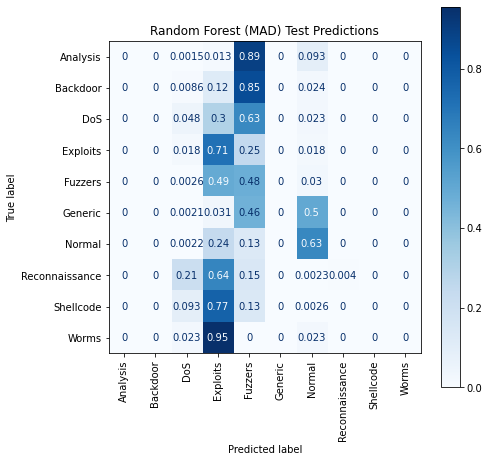

In [33]:
plt_norm_confmat(rf_mad_final, test_std_mad, y_test, 'Random Forest (MAD) Test Predictions', 
                 fname='final_rf_mad_conf_mat', labels=class_names)

In [34]:
joblib.dump(final_rep_dict_rf_mad, './data/final_rep_dict_rf_mad.pkl')

['final_rep_dict_rf_mad.pkl']

In [35]:
joblib.dump(final_conf_mat_rf_mad, './data/final_conf_mat_rf_mad.pkl')

['final_conf_mat_rf_mad.pkl']

### Correlation features

In [36]:
y_pred_final_rf_corr = rf_corr_final.predict(test_std_corr)

In [37]:
final_conf_mat_rf_corr, final_class_rep_rf_corr, final_rep_dict_rf_corr, final_acc_rf_corr = gen_metrics(y_test, y_pred_final_rf_corr)
print(final_class_rep_rf_corr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.02      0.04      0.03       583
           2       0.32      0.63      0.43      4089
           3       0.34      0.69      0.45     11132
           4       0.25      0.34      0.29      6062
           5       0.99      0.96      0.98     18871
           6       0.99      0.60      0.75     37000
           7       0.96      0.36      0.53      3496
           8       0.00      0.00      0.00       378
           9       0.71      0.11      0.20        44

    accuracy                           0.66     82332
   macro avg       0.46      0.37      0.36     82332
weighted avg       0.79      0.66      0.69     82332



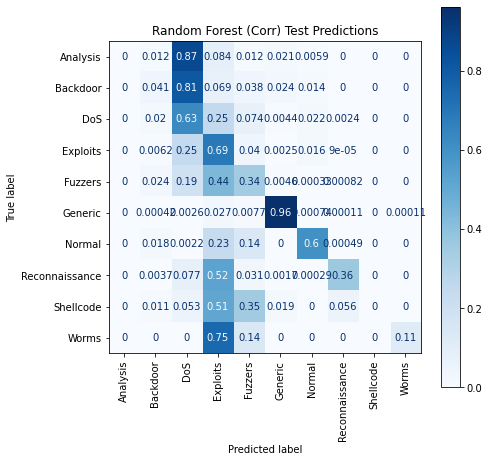

In [38]:
plt_norm_confmat(rf_corr_final, test_std_corr, y_test, 'Random Forest (Corr) Test Predictions', 
                 fname='final_rf_corr_conf_mat', labels=class_names)

In [39]:
joblib.dump(final_rep_dict_rf_corr, './data/final_rep_dict_rf_corr.pkl')

['final_rep_dict_rf_corr.pkl']

In [40]:
joblib.dump(final_conf_mat_rf_corr, './data/final_conf_mat_rf_corr.pkl')

['final_conf_mat_rf_corr.pkl']

### Recursive Feature Elimination features

In [41]:
y_pred_final_rf_rfe = rf_rfe_final.predict(test_std_rfe)

In [42]:
final_conf_mat_rf_rfe, final_class_rep_rf_rfe, final_rep_dict_rf_rfe, final_acc_rf_rfe = gen_metrics(y_test, y_pred_final_rf_rfe)
print(final_class_rep_rf_rfe)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.02      0.07      0.03       583
           2       0.29      0.40      0.34      4089
           3       0.47      0.69      0.56     11132
           4       0.24      0.65      0.35      6062
           5       1.00      0.96      0.98     18871
           6       0.91      0.58      0.71     37000
           7       0.00      0.00      0.00      3496
           8       0.00      0.00      0.00       378
           9       1.00      0.07      0.13        44

    accuracy                           0.64     82332
   macro avg       0.39      0.34      0.31     82332
weighted avg       0.73      0.64      0.66     82332



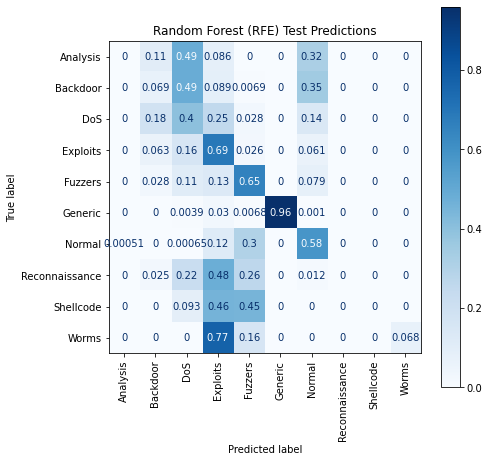

In [43]:
plt_norm_confmat(rf_rfe_final, test_std_rfe, y_test, 'Random Forest (RFE) Test Predictions', 
                 fname='final_rf_rfe_conf_mat', labels=class_names)

In [44]:
joblib.dump(final_rep_dict_rf_rfe, './data/final_rep_dict_rf_rfe.pkl')

['final_rep_dict_rf_rfe.pkl']

In [45]:
joblib.dump(final_conf_mat_rf_rfe, './data/final_conf_mat_rf_rfe.pkl')

['final_conf_mat_rf_rfe.pkl']

### Random Forest optimum features

In [20]:
y_pred_final_rf_RF = rf_RF_final.predict(test_std_RF)

In [21]:
final_conf_mat_rf_RF, final_class_rep_rf_RF, final_rep_dict_rf_RF, final_acc_rf_RF = gen_metrics(y_test, y_pred_final_rf_RF)
print(final_class_rep_rf_RF)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.02      0.08      0.04       583
           2       0.31      0.48      0.38      4089
           3       0.45      0.70      0.55     11132
           4       0.23      0.61      0.33      6062
           5       1.00      0.96      0.98     18871
           6       0.95      0.58      0.72     37000
           7       0.00      0.00      0.00      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.00      0.00        44

    accuracy                           0.64     82332
   macro avg       0.30      0.34      0.30     82332
weighted avg       0.75      0.64      0.67     82332



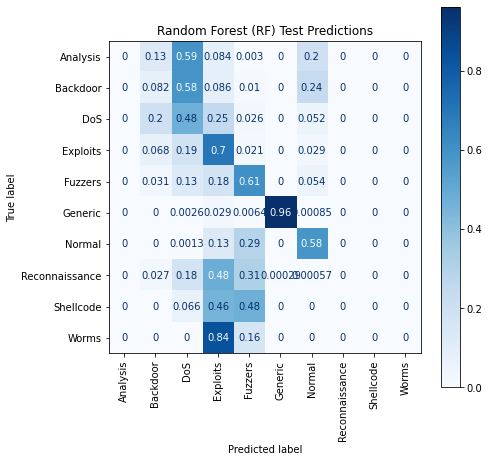

In [22]:
plt_norm_confmat(rf_RF_final, test_std_RF, y_test, 'Random Forest (RF) Test Predictions', 
                 fname='final_rf_RF_conf_mat', labels=class_names)

In [23]:
joblib.dump(final_rep_dict_rf_RF, './data/final_rep_dict_rf_RF.pkl')

['final_rep_dict_rf_RF.pkl']

In [24]:
joblib.dump(final_conf_mat_rf_RF, './data/final_conf_mat_rf_RF.pkl')

['final_conf_mat_rf_RF.pkl']

### All features

In [25]:
def transform_data2(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    # make sure training and testing sets have same features
    add_cols = ['proto_icmp', 'proto_rtp', 'state_ECO', 'state_PAR', 'state_URN', 'state_no']
    drop_cols = ['state_ACC', 'state_CLO']
    for feat in add_cols:
      if feat not in one_hot.columns:
        one_hot[feat] = 0
    for feat in drop_cols:
      if feat in one_hot.columns:
        one_hot = one_hot.drop(feat, axis=1)

    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [26]:
training_data_std, training_labels, training_cats = transform_data2(training_data)
testing_data_std, testing_labels, testing_cats = transform_data2(testing_data)

label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [27]:
y_pred_final_rf_all = rf_all_final.predict(testing_data_std)

In [28]:
final_conf_mat_rf_all, final_class_rep_rf_all, final_rep_dict_rf_all, final_acc_rf_all = gen_metrics(y_test, y_pred_final_rf_all)
print(final_class_rep_rf_all)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.10      0.04      0.06      4089
           3       0.29      0.92      0.45     11132
           4       0.38      0.05      0.10      6062
           5       0.00      0.00      0.00     18871
           6       0.53      0.64      0.58     37000
           7       0.00      0.00      0.00      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.00      0.00        44

    accuracy                           0.42     82332
   macro avg       0.13      0.17      0.12     82332
weighted avg       0.31      0.42      0.33     82332



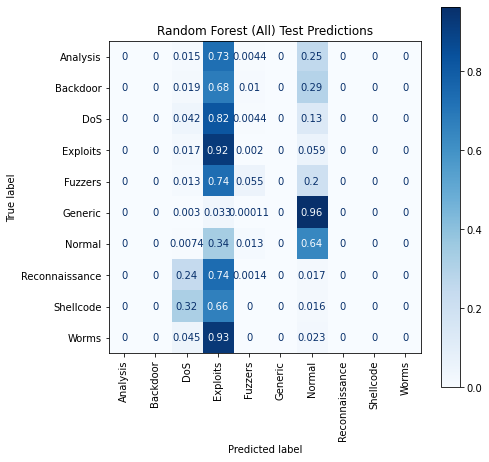

In [29]:
plt_norm_confmat(rf_all_final, testing_data_std, y_test, 'Random Forest (All) Test Predictions', 
                 fname='final_rf_all_conf_mat', labels=class_names)

In [30]:
joblib.dump(final_rep_dict_rf_all, './data/final_rep_dict_rf_all.pkl')

['final_rep_dict_rf_all.pkl']

In [31]:
joblib.dump(final_conf_mat_rf_all, './data/final_conf_mat_rf_all.pkl')

['final_conf_mat_rf_all.pkl']